<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : KASRA MALIHI
### Student Number : 99105742
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = 0.1307, std = 0.3081),])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [15]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transformation, 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transformation
)

# Number of images in the dataset: 60,000
print(train_data.data.size())

# Split the dataset into training and validation sets
t_data, v_data = random_split(train_data, [50000, 10000])

print(train_data)

torch.Size([60000, 28, 28])
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.1307, std=0.3081)
           )


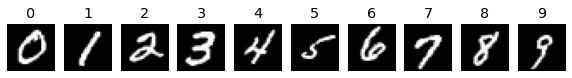

In [16]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 10, 1
t = True
j = 0
i = 0
while t:
  if train_data.targets[j] == i: 
    img, label = train_data[j]
    figure.add_subplot(rows, cols, i+1)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    i += 1
  j +=1
  if i == 10:
    t = False
plt.show()

Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [18]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
batch_size = 16
num_threads = 2
train_loader = torch.utils.data.DataLoader(dataset=t_data,batch_size=batch_size, shuffle=True, num_workers=num_threads)
val_loader = torch.utils.data.DataLoader(dataset=v_data,batch_size=batch_size, shuffle=True, num_workers=num_threads)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [21]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
      super(ResidualClassifier, self).__init__()
      self.conv1 = nn.Conv2d(in_channels= 1, out_channels= 16, kernel_size=3 , padding = 1, stride = 1)
      self.relu1 = nn.ReLU(inplace=True)
      self.max1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
      self.conv21 = nn.Conv2d(in_channels= 16, out_channels= 16, kernel_size=3 , padding = 1, stride = 1)
      self.relu21 = nn.ReLU(inplace=True)
      self.conv22 = nn.Conv2d(in_channels= 16, out_channels= 16, kernel_size=3 , padding = 1, stride = 1)
      self.relu22 = nn.ReLU(inplace=True)
        
      self.max3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
      self.conv3 = nn.Conv2d(in_channels= 16, out_channels= 64, kernel_size=3 , padding = 1, stride = 1)
      self.relu3 = nn.ReLU(inplace=True)

      self.conv41 = nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size=3 , padding = 1, stride = 1)
      self.relu41 = nn.ReLU(inplace=True)
      self.conv42 = nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size=3 , padding = 1, stride = 1)
      self.relu42 = nn.ReLU(inplace=True)

      self.AAP = nn.AdaptiveAvgPool2d(1)

      self.linear5 = nn.Linear(64, 10)
      self.relu5 = nn.ReLU(inplace=True)

    def forward(self,x):
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.max1(x)
      
      res1 = torch.clone(x)
      res1 = self.conv21(res1)
      res1 = self.relu21(res1)
      res1 = self.conv22(res1)
      res1 = self.relu22(res1)

      x = x + res1

      x = self.max3(x)
      x = self.conv3(x)
      x = self.relu3(x)

      res2 = torch.clone(x)
      res2 = self.conv41(res2)
      res2 = self.relu41(res2)
      res2 = self.conv42(res2)
      res2 = self.relu42(res2)

      x = x + res2
      x = self.AAP(x)
      x = x.view(-1, 64*1*1)
      x = self.linear5(x)
      #x = self.relu5(x)
      return x

# Train Model (30 Points)

In [22]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [23]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 20

def test(model, loader, f_loss, device):
    with torch.no_grad():
        model.eval()
        N = 0
        tot_loss, correct = 0.0, 0.0
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            N += inputs.shape[0]
            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()
            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
        return tot_loss/N, correct/N
def train(model, loader, f_loss, optimizer, device):
    model.train()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = f_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
val_loss_list = []
val_acc_list = []
train_loss_list = []
train_acc_list = []
val_loss_min = np.Inf
epochs = 25

for t in range(epochs):
    print("Epoch {}".format(t+1))
    train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = test(model, val_loader, criterion, device)
    train_loss, train_acc = test(model, train_loader, criterion, device)
    if (val_loss < val_loss_min):
      val_loss_min = val_loss
      torch.save(model.state_dict(),'model.pt')
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(" Training : Loss : {:.4f}, Acc : {:.4f}".format(train_loss, train_acc))
    print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))

Epoch 1
 Training : Loss : 0.1426, Acc : 0.9573
 Validation : Loss : 0.1602, Acc : 0.9529
Epoch 2
 Training : Loss : 0.0539, Acc : 0.9833
 Validation : Loss : 0.0636, Acc : 0.9798
Epoch 3
 Training : Loss : 0.0561, Acc : 0.9824
 Validation : Loss : 0.0771, Acc : 0.9776
Epoch 4
 Training : Loss : 0.0379, Acc : 0.9885
 Validation : Loss : 0.0517, Acc : 0.9834
Epoch 5
 Training : Loss : 0.0254, Acc : 0.9921
 Validation : Loss : 0.0386, Acc : 0.9882
Epoch 6
 Training : Loss : 0.0208, Acc : 0.9935
 Validation : Loss : 0.0413, Acc : 0.9876
Epoch 7
 Training : Loss : 0.0225, Acc : 0.9926
 Validation : Loss : 0.0412, Acc : 0.9890
Epoch 8
 Training : Loss : 0.0100, Acc : 0.9969
 Validation : Loss : 0.0316, Acc : 0.9912
Epoch 9
 Training : Loss : 0.0153, Acc : 0.9955
 Validation : Loss : 0.0342, Acc : 0.9896
Epoch 10
 Training : Loss : 0.0144, Acc : 0.9954
 Validation : Loss : 0.0384, Acc : 0.9888
Epoch 11
 Training : Loss : 0.0086, Acc : 0.9973
 Validation : Loss : 0.0325, Acc : 0.9911
Epoch 12

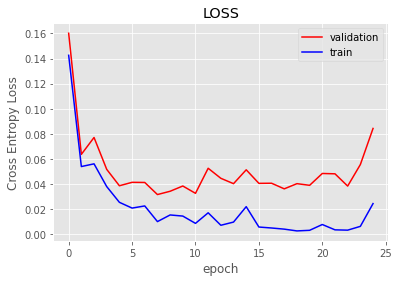

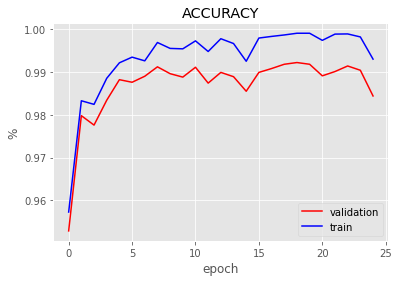

In [24]:
plt.plot(val_loss_list, 'r-',label='validation')
plt.plot(train_loss_list, 'b-',label='train')
plt.title('LOSS')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()
plt.plot(val_acc_list, 'r-',label='validation')
plt.plot(train_acc_list, 'b-',label='train')
plt.title('ACCURACY')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('%')
plt.show()

# Test Model (20 Points)

10000
Accuracy : 99.17%


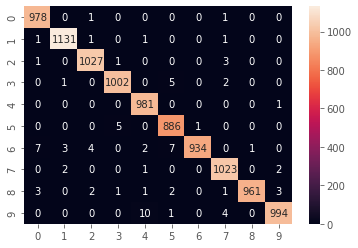

In [25]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=64, shuffle=False, num_workers=num_threads)
print(len(test_data))

model = ResidualClassifier().to(device)
model.load_state_dict(torch.load('model.pt'))
loss = 0
true_predict = 0
y_true = []
y_pred = []
for (data, label) in test_loader:
  output = model(data.to(device))
  pred = torch.argmax(output, dim = 1)
  y_true.append(list(label.cpu().numpy()))
  y_pred.append(list(pred.cpu().numpy()))
  true_predict += torch.sum(pred == label.to(device)).item()
accuracy = true_predict / len(test_loader.sampler)
print('Accuracy : {:.2%}'.format(accuracy))
from itertools import chain
y_true = list(chain.from_iterable(y_true))
y_pred = list(chain.from_iterable(y_pred))
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d')